### Importing libiraries 

In [147]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
import json
from msilib.schema import File
import numpy as np
from nltk_utils import tokenize, stem, bag_of_ward

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
     

## load data

In [148]:
with open('new_dataset.json') as f:
    intents = json.load(f)

## prepareing and preprocessing 

In [149]:
all_word = []
tags = []
xy = []

for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        
        all_word.extend(w)
        xy.append((w, tag))
        
ignor_word = ['?', '.', '!', ',']
all_word = [stem(w) for w in all_word if w not in ignor_word]



all_word = sorted(set(all_word))
tags = sorted(set(tags))

vocab_size = len(all_word)
print(vocab_size)

Xtrain = []
ytrain = []

for (pattern_sentence, tag) in xy:
    bag = bag_of_ward(pattern_sentence, all_word)
    Xtrain.append(bag)

    label = tags.index(tag)
    ytrain.append(label)

Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)
ytrain =pd.get_dummies(ytrain)
ytrain=np.array(ytrain)
print(ytrain.shape)

685
(397, 121)


In [150]:
max_length = Xtrain.shape[1]
max_classes = ytrain.shape[1]
max_length


685

## Train & Test Split

In [151]:
X_train, X_test, y_train, y_test = train_test_split( Xtrain, ytrain, test_size=0.20, random_state=42)
print("X_train")
print(X_train)
print("X_test")
print(X_test)
print("y_train")
print(y_train)
print("y_test")
print(y_test)

X_train
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_test
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y_train
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y_test
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Model

In [152]:
early_stopping = EarlyStopping(monitor='val_loss',patience=30) #patience : number of epochs with no improvement after which training will be stopped

checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'accuracy', factor = 0.2, patience = 10, verbose = 1, min_delta = 0.001)

callbacks = [early_stopping,checkpoint,reduce_lr]

### RNN

In [153]:
def define_model1(max_length,max_classes):
    model1 = Sequential()
    model1.add(Dense(32, input_shape=(max_length,),activation='relu'))
    model1.add(Dense(16,activation='relu'))
    model1.add(Dense(8,activation='relu'))
    model1.add(Dense(max_classes, activation='sigmoid'))   
    model1.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])
    
    # summarize defined model
    model1.summary()
    plot_model(model1, to_file='model_1.png', show_shapes=True)
    return model1

In [154]:
model1 = define_model1(max_length,max_classes)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 32)                21952     
                                                                 
 dense_63 (Dense)            (None, 16)                528       
                                                                 
 dense_64 (Dense)            (None, 8)                 136       
                                                                 
 dense_65 (Dense)            (None, 121)               1089      
                                                                 
Total params: 23,705
Trainable params: 23,705
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [155]:
def define_model5(vocab_size, max_length,max_classes):
    model5 = Sequential()
    model5.add(Embedding(vocab_size,100, input_length=max_length))
    model5.add(SimpleRNN(100))
    model5.add(Dense(max_classes, activation='softmax'))   
    
    model5.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model5.summary()
    plot_model(model1, to_file='model_1.png', show_shapes=True)
    return model5

In [156]:
model5 = define_model5(vocab_size, max_length,max_classes)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 685, 100)          68500     
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 100)               20100     
                                                                 
 dense_66 (Dense)            (None, 121)               12221     
                                                                 
Total params: 100,821
Trainable params: 100,821
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## new model

In [157]:
def define_model2(vocab_size, max_length,max_classes):
    model1 = Sequential()
    model1.add(Embedding(vocab_size,100, input_length=max_length))
    model1.add(SimpleRNN(100))
    model1.add(Dense(max_classes, activation='softmax'))   
    
    model1.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model1.summary()
    plot_model(model1, to_file='model_1.png', show_shapes=True)
    return model1

In [158]:
model2 = define_model2(vocab_size, max_length,max_classes)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 685, 100)          68500     
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 100)               20100     
                                                                 
 dense_67 (Dense)            (None, 121)               12221     
                                                                 
Total params: 100,821
Trainable params: 100,821
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [159]:
def define_model4(vocab_size, max_length,max_classes):
    model4 = Sequential()
    model4.add(Embedding(vocab_size,50, input_length=max_length))
    model4.add(Bidirectional(LSTM(100)))
    model4.add(Dense(max_classes, activation='softmax'))
    
    model4.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model4.summary()
    return model3

In [160]:
model4 = define_model4(vocab_size, max_length,max_classes)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 685, 50)           34250     
                                                                 
 bidirectional_7 (Bidirectio  (None, 200)              120800    
 nal)                                                            
                                                                 
 dense_68 (Dense)            (None, 121)               24321     
                                                                 
Total params: 179,371
Trainable params: 179,371
Non-trainable params: 0
_________________________________________________________________


### LSTM

In [161]:
def define_model3(vocab_size,max_length,max_classes):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(LSTM(500,activation='relu'))
    model3.add(Dense(max_classes, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    return model3

In [162]:
model3 = define_model3(vocab_size, max_length,max_classes)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 685, 300)          205500    
                                                                 
 lstm_17 (LSTM)              (None, 500)               1602000   
                                                                 
 dense_69 (Dense)            (None, 121)               60621     
                                                                 
Total params: 1,868,121
Trainable params: 1,868,121
Non-trainable params: 0
_________________________________________________________________


In [163]:
history1 = model1.fit(Xtrain, ytrain, epochs=100, verbose = 1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/100
 1/13 [=>............................] - ETA: 9s - loss: 4.8001 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 4.78759, saving model to model-v1.h5
13/13 [==============================] - 1s 25ms/step - loss: 4.7958 - accuracy: 0.0076 - val_loss: 4.7876 - val_accuracy: 0.0250 - lr: 0.0010
Epoch 2/100
 7/13 [===============>..............] - ETA: 0s - loss: 4.7827 - accuracy: 0.0134    
Epoch 2: val_loss improved from 4.78759 to 4.77450, saving model to model-v1.h5
13/13 [==============================] - 0s 19ms/step - loss: 4.7832 - accuracy: 0.0176 - val_loss: 4.7745 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/13 [========================>.....] - ETA: 0s - loss: 4.7679 - accuracy: 0.0142    
Epoch 3: val_loss improved from 4.77450 to 4.75537, saving model to model-v1.h5
13/13 [==============================] - 0s 16ms/step - loss: 4.7677 - accuracy: 0.0126 - val_loss: 4.7554 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
10/13 [===========

13/13 [==============================] - 0s 9ms/step - loss: 2.5774 - accuracy: 0.3854 - val_loss: 2.5204 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 27/100
 1/13 [=>............................] - ETA: 0s - loss: 2.4998 - accuracy: 0.4688
Epoch 27: val_loss improved from 2.52041 to 2.38194, saving model to model-v1.h5
13/13 [==============================] - 0s 13ms/step - loss: 2.4524 - accuracy: 0.4106 - val_loss: 2.3819 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 28/100
 1/13 [=>............................] - ETA: 0s - loss: 2.6191 - accuracy: 0.3750
Epoch 28: val_loss improved from 2.38194 to 2.28098, saving model to model-v1.h5
13/13 [==============================] - 0s 7ms/step - loss: 2.3299 - accuracy: 0.4408 - val_loss: 2.2810 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 29/100
 1/13 [=>............................] - ETA: 0s - loss: 2.3399 - accuracy: 0.4375
Epoch 29: val_loss improved from 2.28098 to 2.16678, saving model to model-v1.h5
13/13 [==============================] - 0

 1/13 [=>............................] - ETA: 0s - loss: 0.4541 - accuracy: 0.9688
Epoch 52: val_loss improved from 0.51739 to 0.47576, saving model to model-v1.h5
13/13 [==============================] - 0s 8ms/step - loss: 0.5058 - accuracy: 0.9421 - val_loss: 0.4758 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 53/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5418 - accuracy: 0.9688
Epoch 53: val_loss improved from 0.47576 to 0.44821, saving model to model-v1.h5
13/13 [==============================] - 0s 7ms/step - loss: 0.4681 - accuracy: 0.9446 - val_loss: 0.4482 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 54/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5521 - accuracy: 0.9375
Epoch 54: val_loss improved from 0.44821 to 0.40809, saving model to model-v1.h5
13/13 [==============================] - 0s 8ms/step - loss: 0.4390 - accuracy: 0.9547 - val_loss: 0.4081 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 55/100
 1/13 [=>............................] - ET

Epoch 78/100
13/13 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9975
Epoch 78: val_loss improved from 0.09787 to 0.09190, saving model to model-v1.h5

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
13/13 [==============================] - 0s 19ms/step - loss: 0.1102 - accuracy: 0.9975 - val_loss: 0.0919 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 79/100
13/13 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9975
Epoch 79: val_loss improved from 0.09190 to 0.09089, saving model to model-v1.h5
13/13 [==============================] - 0s 15ms/step - loss: 0.1048 - accuracy: 0.9975 - val_loss: 0.0909 - val_accuracy: 1.0000 - lr: 2.0000e-04
Epoch 80/100
13/13 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9975
Epoch 80: val_loss improved from 0.09089 to 0.08916, saving model to model-v1.h5
13/13 [==============================] - 0s 19ms/step - loss: 0.1033 - accuracy: 0.9975 - val_loss: 

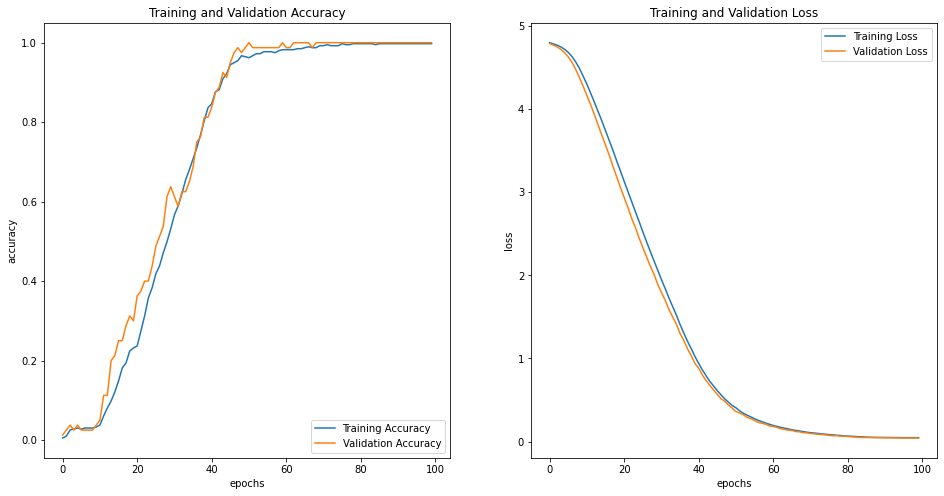

In [146]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

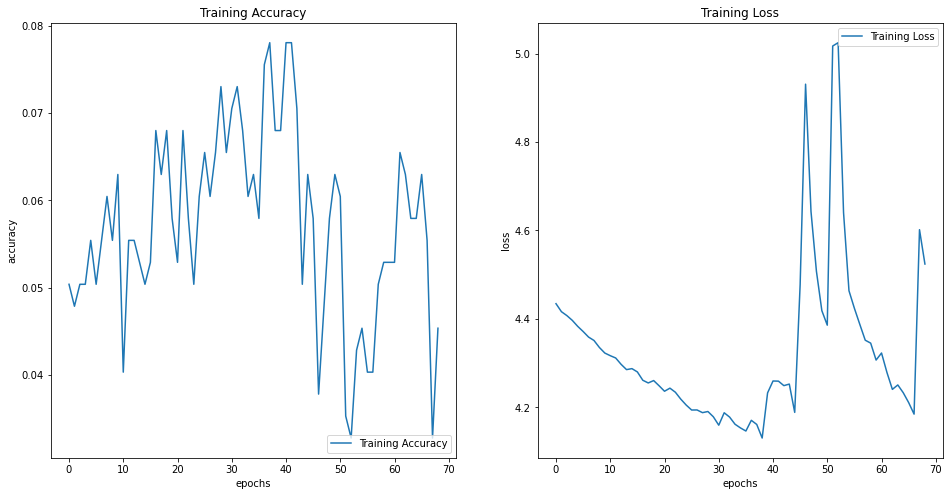

In [95]:
acc = history1.history['accuracy']
loss=history1.history['loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

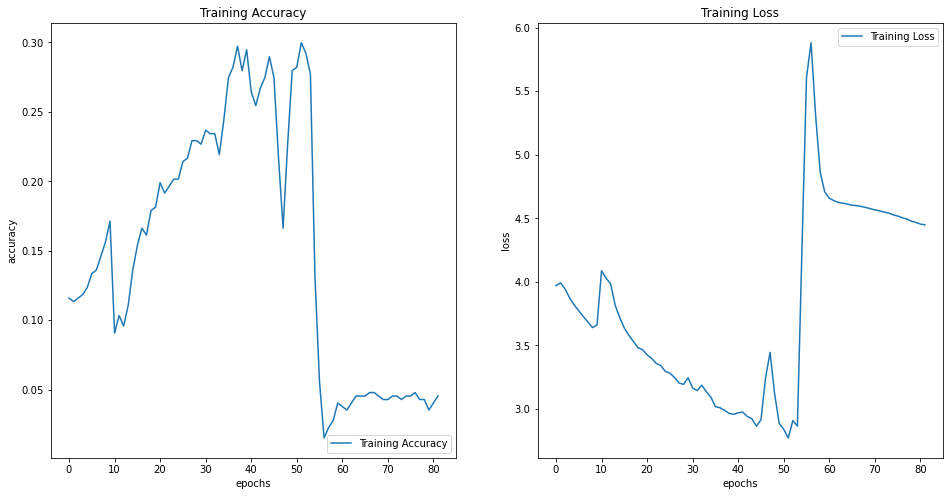

In [93]:
acc = history1.history['accuracy']
loss=history1.history['loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [164]:
Diagnosis1={
    "depreesion":9,
    "anxiety disorder":7,
    "addictive":5,
    "Schizophrenia":8,
    "Postpartum":7,
    "ADHD":5,
    "PTSD":7,
    "education":6,
}
Diagnosis={
    "depreesion":0,
    "anxiety disorder":0,
    "addictive":0,
    "Schizophrenia":0,
    "Postpartum":0,
    "ADHD":0,
    "PTSD":0,
    "education":0,
}
visited = []
def set_state (tag_init):
    tag = tag_init[:len(tag_init)-3]
    signal = tag_init[-1]
    
    if tag_init in visited :
        return
    else:
        visited.append(tag_init)
        #print("msaaaaaaaa",tag,signal)
        if Diagnosis.get(tag,-1)+1 and signal == 'Y':
            Diagnosis[tag]=Diagnosis.get(tag,0)+1

state = []
def calc_state():
    Diagnosis_copy = Diagnosis
    keys=list(Diagnosis_copy.keys())
    #print(keys)
    total= sum(Diagnosis_copy.values())
    #print(total)
    
    for i in keys:
        state.append([i,round(100*Diagnosis_copy[i]/total)])
    state.sort(key = lambda i: i[1],reverse = True)
    visited = []
    Diagnosis_copy = Diagnosis_copy.fromkeys(Diagnosis_copy, 0)

def show_state():
    for i in state:
        if i[1]:
            print(f"{bot_name}: {i[0]} related symptoms {str(i[1])+'%'}")


In [165]:
'''
def keep_track(prev_tag,tag):
    signal = prev_tag[-2]
    if Diagnosis.get(tag[:len(tag)-3],1)-1:
        if tag[:len(tag)-3] != prev_tag.startswith(tag[:len(s2)-3]) and signal == 'C' and Diagnosis.get(tag[:len(tag)-4],1)-1:
            return True
        elif tag[:len(tag)-3] == prev_tag.startswith(tag[:len(s2)-3]):
            return False
        else :
            return False
'''

"\ndef keep_track(prev_tag,tag):\n    signal = prev_tag[-2]\n    if Diagnosis.get(tag[:len(tag)-3],1)-1:\n        if tag[:len(tag)-3] != prev_tag.startswith(tag[:len(s2)-3]) and signal == 'C' and Diagnosis.get(tag[:len(tag)-4],1)-1:\n            return True\n        elif tag[:len(tag)-3] == prev_tag.startswith(tag[:len(s2)-3]):\n            return False\n        else :\n            return False\n"

In [166]:
bot_name = "AI_Chatbot"
flag = 0
print(f"{bot_name}: Hi,how are you i am a AI_Chatbot")
prev_tag = '' 
while True:
    sentence = input('You: ')
    real_sentence = sentence
    if sentence == 'quit':
        break
    if sentence == '!My_state':
        show_state()
        continue
    sentence = tokenize(sentence)
    X = bag_of_ward(sentence, all_word)
    X = X.reshape(1, X.shape[0])
    X = np.array(X)

    output = model1(X)
    predicted = np.argmax(output)
    tag = tags[predicted.item()]
    
    if prev_tag == '':
        prev_tag = tag
        
    if tag[len(tag)-4:] == '_key':
        Diagnosis[tag[:len(tag)-4]] = 1
        #print(Diagnosis)
    probs = np.exp(output)/(np.exp(output).sum())
    prob = probs[0][predicted.item()]
    #print (prob.item())
    if prob.item() > 0:
        
        
        if Diagnosis.get(tag[:len(tag)-3],-1)+1 and Diagnosis[tag[:len(tag)-3]] == 0:
            Diagnosis[tag[:len(tag)-3]] = 1
            if tag[:len(tag)-3] == 'addictive' and Diagnosis['depreesion'] != 0:
                tag = tag 
            else :
                tag = tag[:len(tag)-3]+'_key'
        
        if Diagnosis.get(tag[:len(tag)-3],-1)+1 and tag[-2] == 'E':
            flag = 1
            
        for intent in intents["intents"]:
            if tag == intent["tag"]:   
                set_state(tag)
                #print(Diagnosis)
                print(f"{bot_name}: {np.random.choice(intent['responses'])}")
                prev_tag = tag
                if flag == 1 :
                    calc_state()
                    flag = 0
    else:
        print(f"{bot_name}: I do not understand...")
                
        
'''      
    else:
        #print(f"{bot_name}: {np.random.choice(intent['suggestions'])}")
        #intent['patterns'].append(real_sentence)
        #sentence = input('You: ')
        #if sentence.lower() in 'no,i dont mean this':
        print(f"{bot_name}: I do not understand...")
        #else:
            #print(f"{bot_name}: {np.random.choice(intent['responses'])}")
            # update_data(intents)
''' 

AI_Chatbot: Hi,how are you i am a AI_Chatbot
You: hi
AI_Chatbot: Hello, how are you today?
You: i am not fine 
AI_Chatbot: This is very sad, Why ?
You: Lost pleasure and no longer interested in the usual things
AI_Chatbot: Has it been two weeks or more since this feeling?
You: more than two weeks
AI_Chatbot: Well, now relax and let's discuss step by step how you feel and start with: 
What about your mood do you feel constant sadness ?
You: Yes, I feel some sadness sometimes and I don't know why
AI_Chatbot: well, Do you have a sense of self-confidence, or is it no longer the case and is followed by a sense of inferiority ?
You: No, my self-confidence is not weak. On the contrary, I feel very self-confident
AI_Chatbot: Well, what about life? Does life have value for you or not?
You: No, I am not that desperate, and I don't feel guilty about myself
AI_Chatbot: Greate, the fun activities that you do, do you still do them ?
You: I don't do it anymore, on the contrary, I feel a lack of desir

'      \n    else:\n        #print(f"{bot_name}: {np.random.choice(intent[\'suggestions\'])}")\n        #intent[\'patterns\'].append(real_sentence)\n        #sentence = input(\'You: \')\n        #if sentence.lower() in \'no,i dont mean this\':\n        print(f"{bot_name}: I do not understand...")\n        #else:\n            #print(f"{bot_name}: {np.random.choice(intent[\'responses\'])}")\n            # update_data(intents)\n'